LangGraph integration 


In [1]:
from src.utils import crawl_arxiv_papers 

# crawl_arxiv_papers() # This will always crawl the latest 200 papers regarding AI 

In [2]:
from src.utils import read_quick_info

quick_info = read_quick_info() # quick selection required (maybe some human input on each batch here)

Human-in-the-loop Selection

In [3]:
import random
from typing import Annotated, Literal, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class Paper(TypedDict):
    title: str
    summary: str
    post: str
    comment: str
    score: int
    argument: str # Argument needs to be approved by a human

def add_papers(left: List[Paper], right: List[Paper]) -> List[Paper]:
    # When there are duplicate titles, we merge, otherwise we concatenate
    merged = {paper['title']: paper for paper in left}
    for paper in right:
        if paper['title'] in merged:
            # Merge the papers with the same title
            merged[paper['title']] = Paper(
                title=paper['title'],
                summary=paper['summary'],
                post=paper['post'] if paper['post'] else merged[paper['title']]['post'],
                comment=merged[paper['title']]['comment'] if merged[paper['title']]['comment'] else paper['comment'],
                score=(merged[paper['title']]['score'] + paper['score']) / 2 if merged[paper['title']]['score'] != 0 and paper['score'] != 0 else max(merged[paper['title']]['score'], paper['score']),
                argument=merged[paper['title']]['argument'] if merged[paper['title']]['argument'] else paper['argument']
            )
        else:
            merged[paper['title']] = paper
    return list(merged.values())


class State(TypedDict):
    messages: Annotated[list, add_messages]
    papers: Annotated[list, add_papers]
    
# initial node should


In [7]:
# test paper selection node 
# I think a customized agent for AI research might already worth quite a lot (if we could customize it to be efficient enough)
SELECT_PAPER_PROMPT = """Here is a list of papers with their summaries. \n{paper_string}\nFor each paper, conduct an analysis, provide your comment on the contribution and limitations of the paper, as well as a score between 0 and 100 indicating its importance.
Your response should be in a JSON format as a list of dictionaries. Each dictionary should have the following keys: title, comment, score. For example:
[
    {{
        "title": "Paper Title 1",
        "comment": "Comment on the importance and contribution of the paper",
        "score": 80
    }},
    {{
        "title": "Paper Title 2",
        "comment": "Another comment on a different paper",
        "score": 75
    }}
]

Please provide your analysis for each paper in the list."""


ARGUMENT_PROMPT = """Provide argument on why the paper {paper_title} is the best among the selected papers: {paper_string}"""


from src.utils import papers_to_string, parse_paper_response, initialize_papers, add_papers
from langchain_openai import ChatOpenAI
from src.utils import load_papers

class CrawlNode:
    def __init__(self, name: str, refresh: bool = False):
        self.name = name
        self.path = "cave/arxiv_papers_info.json"
        self.refresh = refresh
    def __call__(self, state: State): # Wonderful, now it works (!) I am starting to like LangGraph now ...
        list_of_papers = load_papers(refresh=self.refresh, file_path=self.path)
        return {"papers": list_of_papers}
    

class SelectNode:
    def __init__(self, batch_id: int, model: ChatOpenAI):
        self.model = model
        self.batch_id = batch_id

    def __call__(self, state: State):
        papers = state["papers"]
        batch_size = 10

        start_index = self.batch_id * batch_size
        end_index = min((self.batch_id + 1) * batch_size, len(papers))

        batch_papers = papers[start_index:end_index]
        paper_string = papers_to_string(batch_papers)
        select_prompt = SELECT_PAPER_PROMPT.format(paper_string=paper_string)

        response = self.model.invoke(select_prompt)
        paper_response = parse_paper_response(response.content)
        processed_batch = initialize_papers(paper_response)
        batch_papers = add_papers(batch_papers, processed_batch) 

        # Update the state with the processed and verified papers
        return {"papers": batch_papers}
    
    
class ArgumentNode:
    def __init__(self, batch_id: int, model: ChatOpenAI):
        self.model = model 
        self.batch_id = batch_id
        
    def __call__(self, state: State):
        papers = state["papers"]
        batch_size = 10
        start_index = self.batch_id * batch_size
        end_index = min((self.batch_id + 1) * batch_size, len(papers))
        batch_papers = papers[start_index:end_index]
        
        best_paper = max(batch_papers, key=lambda x: x['score'])
        best_paper_title = best_paper['title']
        best_paper_string = papers_to_string([best_paper])
        argument_prompt = ARGUMENT_PROMPT.format(paper_title=best_paper_title, paper_string=best_paper_string)
        response = self.model.invoke(argument_prompt)
        best_paper['argument'] = response.content
        return {"papers": best_paper}
    
# Human Approval Node - focus on paper with argument over its batch 
class HumanApprovalNode:
    def __init__(self, batch_id: int, model: ChatOpenAI):
        self.model = model
        self.batch_id = batch_id
        
    def __call__(self, state: State):
        papers = state["papers"]
        raise NotImplementedError("Human Approval Node is not implemented yet")
    
    

In [ ]:
def add_fractal_nodes(builder, current_node, level, max_level):
    if level > max_level:
        return

    # Number of nodes to create at this level
    node_names = [f"Paper_Batch_{i}" for i in range(20)]
    num_nodes = random.randint(1, 3)  # Adjust randomness as needed
    for i in range(num_nodes):
        nm = node_names[i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, SelectNode(node_name))
        builder.add_edge(current_node, node_name)

        # Recursively add more nodes
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level + 1, max_level)
        elif r > 0.05:
            builder.add_conditional_edges(node_name, route, node_name)
        else:
            # End
            builder.add_edge(node_name, "__end__")

In [4]:

        
    
def build_research_graph(): # Researcher LangGraph Agent
    builder = StateGraph(State)
    entry_point = "crawl_arxiv_node"
    builder.add_node(entry_point, CrawlNode(entry_point))
    builder.add_edge(START, entry_point)

    # Pending a paper selection node, and a human selection node
    # LLM call on each paper to provide comment and a score
    # We would ask it to do a comparative analysis on each cluster and ask human's verification

    # Optional: set a finish point if required
    builder.add_edge(entry_point, END)  # or any specific node

    return builder.compile()



In [5]:
app = build_research_graph()
# help me run this thing

# Run the graph
result = app.invoke({
    "messages": [],
    "papers": []
})

# Print the result
print("Graph execution result:")
print(result)


Graph execution result:
{'messages': [], 'papers': [{'title': 'Transformer Explainer: Interactive Learning of Text-Generative Models', 'summary': "Transformers have revolutionized machine learning, yet their inner workings\nremain opaque to many. We present Transformer Explainer, an interactive\nvisualization tool designed for non-experts to learn about Transformers through\nthe GPT-2 model. Our tool helps users understand complex Transformer concepts\nby integrating a model overview and enabling smooth transitions across\nabstraction levels of mathematical operations and model structures. It runs a\nlive GPT-2 instance locally in the user's browser, empowering users to\nexperiment with their own input and observe in real-time how the internal\ncomponents and parameters of the Transformer work together to predict the next\ntokens. Our tool requires no installation or special hardware, broadening the\npublic's education access to modern generative AI techniques. Our open-sourced\ntool i

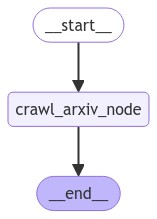

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
import glob 
from src.utils import get_pdf_contents, get_oai_response

# Detailed Read 

# Loading Paper from the Cave 
dir_path = "cave/paper"
files = glob.glob(dir_path + "/*.pdf")

# Reading Paper one by one 
for file in files: 
    imgs = get_pdf_contents(file, first_page=1, last_page=3)
    get_oai_response(prompt="What is the main idea of this paper?", img=imgs, img_type="image/png")
    